In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [4]:
def model_input(state_size, hidden_size, batch_size=1):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    # RNN
    cell = tf.nn.rnn_cell.GRUCell(hidden_size)
    #cell = tf.nn.rnn_cell.LSTMCell(hidden_size)
    cells = tf.nn.rnn_cell.MultiRNNCell([cell], state_is_tuple=False)
    initial_state = cells.zero_state(batch_size, tf.float32)
    return states, actions, targetQs, cells, initial_state

In [5]:
def actor(states, action_size, initial_state, cells, hidden_size, reuse=False): 
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=hidden_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size and
        # static means can NOT adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, hidden_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cells, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state)
        outputs = tf.reshape(outputs_rnn, [-1, hidden_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=action_size)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [13]:
def model_loss(action_size, hidden_size, 
               states, actions, targetQs, 
               cells, initial_state):
    actions_logits, final_state = actor(hidden_size=hidden_size, action_size=action_size, 
                                        states=states, cells=cells, initial_state=initial_state)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, final_state, loss

In [14]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]

    # # Optimize MLP/CNN
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    # #opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    # # Optimize RNN
    #grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(loss, g_vars), clip_norm=5) # usually around 1-5
    grads = tf.gradients(loss, a_vars)
    opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(grads, a_vars))
    return opt

In [15]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, cells, self.initial_state = model_input(
                state_size=state_size, hidden_size=hidden_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.final_state, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, cells=cells, initial_state=self.initial_state)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [21]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [29]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [30]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

(?, 4) (?, 8)
(1, ?, 8) Tensor("MultiRNNCellZeroState/MultiRNNCellZeroState/zeros:0", shape=(1, 8), dtype=float32)
(1, ?, 8) Tensor("actor/rnn/while/Exit_3:0", shape=(1, 8), dtype=float32)
(?, 8)
(?, 2)


In [31]:
model.initial_state#[0]

<tf.Tensor 'MultiRNNCellZeroState/MultiRNNCellZeroState/zeros:0' shape=(1, 8) dtype=float32>

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [32]:
import numpy as np

In [33]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    memory.states.append(np.zeros([1, hidden_size])) # gru
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

In [34]:
memory.states[0].shape, model.initial_state[0].shape # gru
# memory.states[0][1].shape, model.initial_state[0][1].shape #lstm

((1, 8), TensorShape([Dimension(8)]))

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [35]:
# initial_states = np.array(memory.states)
# initial_states.shape

In [19]:
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()
        initial_state = sess.run(model.initial_state)

        # Training steps/batches
        while True:
            action_logits, final_state = sess.run([model.actions_logits, model.final_state],
                                                  feed_dict = {model.states: state.reshape([1, -1]), 
                                                               model.initial_state: initial_state})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append(initial_state)
            total_reward += reward
            state = next_state
            initial_state = final_state

            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            initial_states = memory.states
            next_actions_logits = sess.run(model.actions_logits, 
                                           feed_dict = {model.states: next_states,
                                                        model.initial_state: initial_states[1]})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs,
                                                                     model.initial_state: initial_states[0]})
            # End of training
            loss_batch.append(loss)
            if done is True:
                break
                
        # Outputing: priting out/Potting
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:10.0000 R:10.0000 loss:0.9466
Episode:1 meanR:9.5000 R:9.0000 loss:0.9717
Episode:2 meanR:9.6667 R:10.0000 loss:0.9813
Episode:3 meanR:9.7500 R:10.0000 loss:0.9320
Episode:4 meanR:9.6000 R:9.0000 loss:0.8651
Episode:5 meanR:9.6667 R:10.0000 loss:0.8751
Episode:6 meanR:9.4286 R:8.0000 loss:0.9119
Episode:7 meanR:9.3750 R:9.0000 loss:1.0208
Episode:8 meanR:9.3333 R:9.0000 loss:1.0832
Episode:9 meanR:9.4000 R:10.0000 loss:1.2172
Episode:10 meanR:9.3636 R:9.0000 loss:1.4853
Episode:11 meanR:9.4167 R:10.0000 loss:1.8847
Episode:12 meanR:9.5385 R:11.0000 loss:2.1915
Episode:13 meanR:9.4286 R:8.0000 loss:2.5830
Episode:14 meanR:9.4000 R:9.0000 loss:2.8720
Episode:15 meanR:9.4375 R:10.0000 loss:3.2361
Episode:16 meanR:9.5294 R:11.0000 loss:3.7601
Episode:17 meanR:9.5000 R:9.0000 loss:4.3980
Episode:18 meanR:9.4211 R:8.0000 loss:4.5831
Episode:19 meanR:9.4000 R:9.0000 loss:5.0811
Episode:20 meanR:9.4286 R:10.0000 loss:5.3306
Episode:21 meanR:9.4545 R:10.0000 loss:5.7862
Episode:

Episode:174 meanR:39.9300 R:88.0000 loss:1.3709
Episode:175 meanR:40.3400 R:61.0000 loss:1.7019
Episode:176 meanR:40.5600 R:39.0000 loss:2.1339
Episode:177 meanR:40.8400 R:41.0000 loss:5.0626
Episode:178 meanR:41.0200 R:33.0000 loss:6.7507
Episode:179 meanR:41.2600 R:36.0000 loss:9.0429
Episode:180 meanR:41.4200 R:30.0000 loss:9.3467
Episode:181 meanR:41.6100 R:32.0000 loss:7.7802
Episode:182 meanR:41.8300 R:37.0000 loss:3.9154
Episode:183 meanR:41.8600 R:21.0000 loss:3.0387
Episode:184 meanR:41.8700 R:17.0000 loss:4.7473
Episode:185 meanR:41.8000 R:14.0000 loss:6.1086
Episode:186 meanR:41.6700 R:11.0000 loss:9.2567
Episode:187 meanR:41.5300 R:13.0000 loss:10.3212
Episode:188 meanR:41.3800 R:14.0000 loss:12.3853
Episode:189 meanR:41.0900 R:10.0000 loss:13.9677
Episode:190 meanR:40.9500 R:12.0000 loss:14.9056
Episode:191 meanR:40.7200 R:11.0000 loss:15.9972
Episode:192 meanR:40.4400 R:11.0000 loss:16.6787
Episode:193 meanR:39.2800 R:11.0000 loss:16.6788
Episode:194 meanR:38.3800 R:10.00

Episode:340 meanR:243.1400 R:500.0000 loss:1.0149
Episode:341 meanR:246.8800 R:500.0000 loss:13.7271
Episode:342 meanR:251.4800 R:500.0000 loss:13.9365
Episode:343 meanR:252.0600 R:137.0000 loss:37.0378
Episode:344 meanR:256.6800 R:500.0000 loss:5.7853
Episode:345 meanR:256.7300 R:40.0000 loss:29.6143
Episode:346 meanR:257.2500 R:99.0000 loss:53.9876
Episode:347 meanR:258.7300 R:500.0000 loss:5.1743
Episode:348 meanR:263.3100 R:500.0000 loss:14.5453
Episode:349 meanR:268.0200 R:500.0000 loss:15.0684
Episode:350 meanR:272.6800 R:500.0000 loss:8.1204
Episode:351 meanR:272.9300 R:139.0000 loss:50.3101
Episode:352 meanR:274.3700 R:500.0000 loss:3.7215
Episode:353 meanR:278.8700 R:500.0000 loss:14.3018
Episode:354 meanR:283.4800 R:500.0000 loss:14.4037
Episode:355 meanR:284.4200 R:133.0000 loss:55.9728
Episode:356 meanR:288.8500 R:500.0000 loss:5.4652
Episode:357 meanR:292.9700 R:500.0000 loss:14.7335
Episode:358 meanR:293.1900 R:500.0000 loss:14.5043
Episode:359 meanR:293.2600 R:263.0000 l

Episode:502 meanR:452.0800 R:500.0000 loss:15.0376
Episode:503 meanR:452.0800 R:500.0000 loss:14.1259
Episode:504 meanR:452.0800 R:500.0000 loss:15.4645
Episode:505 meanR:452.0800 R:500.0000 loss:15.5813
Episode:506 meanR:452.0800 R:500.0000 loss:14.6340
Episode:507 meanR:452.0800 R:500.0000 loss:13.8003
Episode:508 meanR:447.6800 R:60.0000 loss:65.6584
Episode:509 meanR:447.6800 R:500.0000 loss:20.1499
Episode:510 meanR:448.4700 R:500.0000 loss:15.8791
Episode:511 meanR:449.0100 R:500.0000 loss:15.0500
Episode:512 meanR:449.0100 R:500.0000 loss:14.6438
Episode:513 meanR:449.0100 R:500.0000 loss:11.9358
Episode:514 meanR:449.0100 R:500.0000 loss:15.1000
Episode:515 meanR:449.0100 R:500.0000 loss:15.4813
Episode:516 meanR:449.0100 R:500.0000 loss:17.2428
Episode:517 meanR:449.0100 R:500.0000 loss:16.1965
Episode:518 meanR:453.0400 R:500.0000 loss:16.6192
Episode:519 meanR:448.2200 R:18.0000 loss:70.0583
Episode:520 meanR:443.4500 R:23.0000 loss:135.9702
Episode:521 meanR:438.6000 R:15.0

Episode:666 meanR:126.0900 R:41.0000 loss:2.8356
Episode:667 meanR:126.1300 R:46.0000 loss:3.1665
Episode:668 meanR:126.1300 R:39.0000 loss:3.2145
Episode:669 meanR:126.2600 R:50.0000 loss:3.9140
Episode:670 meanR:123.8800 R:49.0000 loss:2.8786
Episode:671 meanR:123.9300 R:47.0000 loss:2.2828
Episode:672 meanR:123.9900 R:47.0000 loss:2.1768
Episode:673 meanR:124.0400 R:42.0000 loss:2.2579
Episode:674 meanR:124.0100 R:38.0000 loss:1.5757
Episode:675 meanR:123.9200 R:40.0000 loss:2.0809
Episode:676 meanR:124.1700 R:43.0000 loss:2.2646
Episode:677 meanR:124.4900 R:47.0000 loss:2.8177
Episode:678 meanR:124.7400 R:45.0000 loss:2.3052
Episode:679 meanR:124.8600 R:30.0000 loss:1.4729
Episode:680 meanR:125.0300 R:39.0000 loss:2.4140
Episode:681 meanR:125.0700 R:44.0000 loss:2.5393
Episode:682 meanR:125.0600 R:40.0000 loss:2.7993
Episode:683 meanR:120.4500 R:39.0000 loss:2.8994
Episode:684 meanR:120.1500 R:45.0000 loss:2.3954
Episode:685 meanR:119.8700 R:34.0000 loss:2.4856
Episode:686 meanR:11

Episode:830 meanR:223.9600 R:407.0000 loss:1.1647
Episode:831 meanR:226.3100 R:258.0000 loss:1.6040
Episode:832 meanR:231.1500 R:500.0000 loss:0.8150
Episode:833 meanR:236.0100 R:500.0000 loss:14.6466
Episode:834 meanR:238.2500 R:240.0000 loss:27.4144
Episode:835 meanR:243.1000 R:500.0000 loss:6.0381
Episode:836 meanR:239.5100 R:141.0000 loss:59.5841
Episode:837 meanR:236.0900 R:158.0000 loss:6.8649
Episode:838 meanR:236.0900 R:500.0000 loss:11.4757
Episode:839 meanR:236.0900 R:500.0000 loss:18.6840
Episode:840 meanR:236.0900 R:500.0000 loss:19.7381
Episode:841 meanR:233.2300 R:214.0000 loss:44.0383
Episode:842 meanR:228.4100 R:18.0000 loss:75.3575
Episode:843 meanR:223.5600 R:15.0000 loss:154.3366
Episode:844 meanR:220.7700 R:221.0000 loss:90.1669
Episode:845 meanR:218.2400 R:247.0000 loss:35.2841
Episode:846 meanR:214.4700 R:123.0000 loss:62.7152
Episode:847 meanR:211.6600 R:219.0000 loss:4.4116
Episode:848 meanR:209.5300 R:287.0000 loss:27.1204
Episode:849 meanR:206.7000 R:217.0000 

Episode:992 meanR:455.2700 R:500.0000 loss:2.4454
Episode:993 meanR:450.4000 R:13.0000 loss:71.3724
Episode:994 meanR:450.4000 R:500.0000 loss:22.8415
Episode:995 meanR:450.4000 R:500.0000 loss:18.5081
Episode:996 meanR:450.4000 R:500.0000 loss:20.4431
Episode:997 meanR:450.4000 R:500.0000 loss:22.6341
Episode:998 meanR:450.4000 R:500.0000 loss:13.0917
Episode:999 meanR:450.4000 R:500.0000 loss:16.8120
Episode:1000 meanR:450.4000 R:500.0000 loss:22.8528
Episode:1001 meanR:450.4000 R:500.0000 loss:22.6300
Episode:1002 meanR:450.4000 R:500.0000 loss:23.1807
Episode:1003 meanR:450.4000 R:500.0000 loss:22.3796
Episode:1004 meanR:450.4000 R:500.0000 loss:22.4526
Episode:1005 meanR:450.4000 R:500.0000 loss:22.3794
Episode:1006 meanR:450.4000 R:500.0000 loss:12.8954
Episode:1007 meanR:447.5900 R:219.0000 loss:42.8332
Episode:1008 meanR:447.5900 R:500.0000 loss:16.9497
Episode:1009 meanR:447.5900 R:500.0000 loss:21.8817
Episode:1010 meanR:452.4800 R:500.0000 loss:18.8940
Episode:1011 meanR:457

Episode:1151 meanR:374.6900 R:145.0000 loss:20.9904
Episode:1152 meanR:375.7300 R:500.0000 loss:5.2870
Episode:1153 meanR:379.9300 R:500.0000 loss:16.1116
Episode:1154 meanR:381.9600 R:299.0000 loss:23.1987
Episode:1155 meanR:385.6000 R:500.0000 loss:5.5551
Episode:1156 meanR:389.6100 R:500.0000 loss:18.3620
Episode:1157 meanR:390.1000 R:147.0000 loss:61.5900
Episode:1158 meanR:390.5400 R:134.0000 loss:13.8267
Episode:1159 meanR:391.4200 R:147.0000 loss:30.4033
Episode:1160 meanR:389.7400 R:138.0000 loss:23.4776
Episode:1161 meanR:388.8900 R:129.0000 loss:9.9018
Episode:1162 meanR:387.9500 R:114.0000 loss:8.9833
Episode:1163 meanR:388.0900 R:106.0000 loss:9.2946
Episode:1164 meanR:388.5500 R:102.0000 loss:8.7089
Episode:1165 meanR:388.4400 R:23.0000 loss:15.6806
Episode:1166 meanR:387.5700 R:104.0000 loss:59.6511
Episode:1167 meanR:382.7200 R:15.0000 loss:64.0041
Episode:1168 meanR:380.7700 R:20.0000 loss:119.9972
Episode:1169 meanR:376.6700 R:90.0000 loss:104.0630
Episode:1170 meanR:3

Episode:1310 meanR:437.9600 R:144.0000 loss:28.6224
Episode:1311 meanR:433.2200 R:26.0000 loss:45.9856
Episode:1312 meanR:431.1400 R:292.0000 loss:45.0757
Episode:1313 meanR:428.4800 R:234.0000 loss:42.4329
Episode:1314 meanR:431.9500 R:500.0000 loss:18.2597
Episode:1315 meanR:431.9500 R:500.0000 loss:17.4086
Episode:1316 meanR:431.9500 R:500.0000 loss:16.9966
Episode:1317 meanR:435.3400 R:500.0000 loss:17.4773
Episode:1318 meanR:437.5700 R:366.0000 loss:16.5724
Episode:1319 meanR:434.9900 R:242.0000 loss:17.3282
Episode:1320 meanR:438.5300 R:488.0000 loss:9.9593
Episode:1321 meanR:438.5300 R:500.0000 loss:3.0115
Episode:1322 meanR:438.2700 R:474.0000 loss:11.9724
Episode:1323 meanR:438.2700 R:500.0000 loss:6.9459
Episode:1324 meanR:436.6600 R:156.0000 loss:31.7722
Episode:1325 meanR:433.2000 R:154.0000 loss:5.1844
Episode:1326 meanR:429.7000 R:150.0000 loss:1.9576
Episode:1327 meanR:426.3500 R:165.0000 loss:1.7084
Episode:1328 meanR:423.1800 R:183.0000 loss:2.1563
Episode:1329 meanR:4

Episode:1470 meanR:282.4100 R:500.0000 loss:12.6308
Episode:1471 meanR:282.4100 R:500.0000 loss:9.0230
Episode:1472 meanR:283.0300 R:272.0000 loss:14.6518
Episode:1473 meanR:285.3100 R:500.0000 loss:0.6321
Episode:1474 meanR:282.3400 R:203.0000 loss:38.8058
Episode:1475 meanR:281.7900 R:132.0000 loss:2.4687
Episode:1476 meanR:280.2500 R:36.0000 loss:3.7458
Episode:1477 meanR:278.1400 R:37.0000 loss:16.8328
Episode:1478 meanR:273.6000 R:46.0000 loss:16.0509
Episode:1479 meanR:273.0400 R:141.0000 loss:8.7782
Episode:1480 meanR:276.7900 R:500.0000 loss:0.6908
Episode:1481 meanR:280.7100 R:500.0000 loss:10.1872
Episode:1482 meanR:284.5700 R:500.0000 loss:6.3358
Episode:1483 meanR:288.4300 R:500.0000 loss:14.3003
Episode:1484 meanR:292.3400 R:500.0000 loss:17.2019
Episode:1485 meanR:296.2900 R:500.0000 loss:13.2613
Episode:1486 meanR:299.3700 R:411.0000 loss:12.2065
Episode:1487 meanR:300.8500 R:249.0000 loss:9.5161
Episode:1488 meanR:301.6200 R:183.0000 loss:4.5116
Episode:1489 meanR:303.2

Episode:1630 meanR:409.6300 R:500.0000 loss:14.4647
Episode:1631 meanR:411.1400 R:500.0000 loss:15.0834
Episode:1632 meanR:412.6700 R:500.0000 loss:14.2943
Episode:1633 meanR:414.7800 R:500.0000 loss:15.4342
Episode:1634 meanR:417.2600 R:500.0000 loss:14.3548
Episode:1635 meanR:419.0600 R:500.0000 loss:16.3245
Episode:1636 meanR:414.1900 R:13.0000 loss:85.1288
Episode:1637 meanR:409.3100 R:12.0000 loss:154.1631
Episode:1638 meanR:405.7300 R:142.0000 loss:71.0915
Episode:1639 meanR:408.4100 R:500.0000 loss:2.9012
Episode:1640 meanR:409.9500 R:500.0000 loss:14.3191
Episode:1641 meanR:411.0600 R:500.0000 loss:13.5572
Episode:1642 meanR:411.0600 R:500.0000 loss:14.3109
Episode:1643 meanR:411.0600 R:500.0000 loss:15.2254
Episode:1644 meanR:411.0600 R:500.0000 loss:13.1064
Episode:1645 meanR:411.0600 R:500.0000 loss:13.4824
Episode:1646 meanR:411.0600 R:500.0000 loss:12.5745
Episode:1647 meanR:411.0600 R:500.0000 loss:12.7501
Episode:1648 meanR:411.0600 R:500.0000 loss:16.6991
Episode:1649 m

Episode:1788 meanR:466.1900 R:500.0000 loss:17.1173
Episode:1789 meanR:466.1900 R:500.0000 loss:15.0530
Episode:1790 meanR:461.9200 R:73.0000 loss:61.7843
Episode:1791 meanR:457.0300 R:11.0000 loss:108.0183
Episode:1792 meanR:452.1500 R:12.0000 loss:150.2225
Episode:1793 meanR:447.2700 R:12.0000 loss:175.0611
Episode:1794 meanR:442.3700 R:10.0000 loss:183.0229
Episode:1795 meanR:437.4700 R:10.0000 loss:183.7950
Episode:1796 meanR:432.5700 R:10.0000 loss:140.7741
Episode:1797 meanR:428.3000 R:73.0000 loss:67.7508
Episode:1798 meanR:428.3000 R:500.0000 loss:10.6552
Episode:1799 meanR:428.3000 R:500.0000 loss:12.0219
Episode:1800 meanR:428.3000 R:500.0000 loss:12.8664
Episode:1801 meanR:428.3000 R:500.0000 loss:13.6937
Episode:1802 meanR:428.3000 R:500.0000 loss:17.3082
Episode:1803 meanR:428.3000 R:500.0000 loss:16.2961
Episode:1804 meanR:428.3000 R:500.0000 loss:16.7203
Episode:1805 meanR:428.3000 R:500.0000 loss:16.0906
Episode:1806 meanR:428.3000 R:500.0000 loss:14.5323
Episode:1807 m

Episode:1947 meanR:356.7500 R:273.0000 loss:3.1961
Episode:1948 meanR:356.7500 R:500.0000 loss:6.7628
Episode:1949 meanR:356.7500 R:500.0000 loss:1.6956
Episode:1950 meanR:356.7500 R:500.0000 loss:7.4509
Episode:1951 meanR:355.3300 R:358.0000 loss:23.8717
Episode:1952 meanR:352.8800 R:255.0000 loss:6.2024
Episode:1953 meanR:352.8000 R:492.0000 loss:6.9721
Episode:1954 meanR:357.3400 R:500.0000 loss:5.8100
Episode:1955 meanR:357.3400 R:500.0000 loss:13.1424
Episode:1956 meanR:357.3400 R:500.0000 loss:12.8735
Episode:1957 meanR:357.3400 R:500.0000 loss:18.8224
Episode:1958 meanR:357.3400 R:500.0000 loss:18.4122
Episode:1959 meanR:357.3400 R:500.0000 loss:16.0992
Episode:1960 meanR:357.3400 R:500.0000 loss:12.5490
Episode:1961 meanR:357.3400 R:500.0000 loss:12.0559
Episode:1962 meanR:357.3400 R:500.0000 loss:18.8201
Episode:1963 meanR:357.3400 R:500.0000 loss:15.1780
Episode:1964 meanR:357.3400 R:500.0000 loss:12.6834
Episode:1965 meanR:357.3400 R:500.0000 loss:16.1479
Episode:1966 meanR:

Episode:2106 meanR:385.9600 R:500.0000 loss:7.6516
Episode:2107 meanR:383.3600 R:240.0000 loss:34.2809
Episode:2108 meanR:379.9700 R:161.0000 loss:16.7386
Episode:2109 meanR:376.7200 R:157.0000 loss:3.3023
Episode:2110 meanR:379.9200 R:386.0000 loss:2.6958
Episode:2111 meanR:379.9200 R:500.0000 loss:1.0906
Episode:2112 meanR:379.9200 R:500.0000 loss:12.9546
Episode:2113 meanR:379.9200 R:500.0000 loss:12.4162
Episode:2114 meanR:379.9200 R:500.0000 loss:8.2367
Episode:2115 meanR:377.7800 R:286.0000 loss:29.9716
Episode:2116 meanR:377.7800 R:500.0000 loss:10.1583
Episode:2117 meanR:374.8900 R:211.0000 loss:39.1387
Episode:2118 meanR:374.8900 R:500.0000 loss:5.1639
Episode:2119 meanR:374.8900 R:500.0000 loss:15.8904
Episode:2120 meanR:374.8900 R:500.0000 loss:6.0428
Episode:2121 meanR:374.8900 R:500.0000 loss:14.7402
Episode:2122 meanR:374.8900 R:500.0000 loss:11.9360
Episode:2123 meanR:374.8900 R:500.0000 loss:13.2897
Episode:2124 meanR:378.0500 R:500.0000 loss:15.1591
Episode:2125 meanR:

Episode:2264 meanR:482.5300 R:500.0000 loss:15.1715
Episode:2265 meanR:482.5300 R:500.0000 loss:16.2896
Episode:2266 meanR:478.7300 R:120.0000 loss:68.9928
Episode:2267 meanR:478.7300 R:500.0000 loss:7.1647
Episode:2268 meanR:478.7300 R:500.0000 loss:25.1750
Episode:2269 meanR:478.7300 R:500.0000 loss:16.0956
Episode:2270 meanR:478.7300 R:500.0000 loss:15.9912
Episode:2271 meanR:478.7300 R:500.0000 loss:15.5635
Episode:2272 meanR:478.7300 R:500.0000 loss:16.5629
Episode:2273 meanR:482.9100 R:500.0000 loss:15.1964
Episode:2274 meanR:482.9100 R:500.0000 loss:14.9016
Episode:2275 meanR:482.9100 R:500.0000 loss:15.5620
Episode:2276 meanR:482.9100 R:500.0000 loss:14.9978
Episode:2277 meanR:482.9100 R:500.0000 loss:14.8442
Episode:2278 meanR:482.9100 R:500.0000 loss:10.7193
Episode:2279 meanR:481.4000 R:349.0000 loss:20.2065
Episode:2280 meanR:476.5300 R:13.0000 loss:81.7624
Episode:2281 meanR:476.5300 R:500.0000 loss:14.5140
Episode:2282 meanR:476.5300 R:500.0000 loss:18.9540
Episode:2283 m

Episode:2423 meanR:324.3000 R:12.0000 loss:120.5966
Episode:2424 meanR:324.3000 R:500.0000 loss:26.7408
Episode:2425 meanR:324.3000 R:500.0000 loss:16.6858
Episode:2426 meanR:319.4200 R:12.0000 loss:78.0924
Episode:2427 meanR:318.0600 R:364.0000 loss:31.1670
Episode:2428 meanR:314.6200 R:156.0000 loss:27.3771
Episode:2429 meanR:312.3600 R:274.0000 loss:11.6549
Episode:2430 meanR:308.5100 R:115.0000 loss:35.1442
Episode:2431 meanR:308.1300 R:462.0000 loss:7.0572
Episode:2432 meanR:308.1300 R:500.0000 loss:5.1496
Episode:2433 meanR:308.1300 R:500.0000 loss:16.1954
Episode:2434 meanR:308.1300 R:500.0000 loss:15.6437
Episode:2435 meanR:308.1300 R:500.0000 loss:10.4221
Episode:2436 meanR:307.9600 R:483.0000 loss:24.3008
Episode:2437 meanR:307.9600 R:500.0000 loss:7.7847
Episode:2438 meanR:307.9600 R:500.0000 loss:10.2491
Episode:2439 meanR:307.9600 R:500.0000 loss:16.8457
Episode:2440 meanR:307.9600 R:500.0000 loss:19.6080
Episode:2441 meanR:312.8300 R:500.0000 loss:18.3876
Episode:2442 mea

Episode:2582 meanR:351.4800 R:500.0000 loss:12.4924
Episode:2583 meanR:351.4800 R:500.0000 loss:13.4293
Episode:2584 meanR:351.4800 R:500.0000 loss:13.2396
Episode:2585 meanR:354.6500 R:500.0000 loss:15.5116
Episode:2586 meanR:358.2700 R:500.0000 loss:117.0688
Episode:2587 meanR:361.6700 R:357.0000 loss:7.3295
Episode:2588 meanR:363.9800 R:377.0000 loss:5.5201
Episode:2589 meanR:364.5600 R:133.0000 loss:5.7452
Episode:2590 meanR:364.2600 R:132.0000 loss:10.6777
Episode:2591 meanR:364.5800 R:130.0000 loss:7.0425
Episode:2592 meanR:360.9000 R:132.0000 loss:6.5906
Episode:2593 meanR:357.2800 R:138.0000 loss:6.9168
Episode:2594 meanR:353.6500 R:137.0000 loss:5.7607
Episode:2595 meanR:353.2600 R:135.0000 loss:6.1598
Episode:2596 meanR:349.5700 R:131.0000 loss:5.9018
Episode:2597 meanR:345.8600 R:129.0000 loss:4.7437
Episode:2598 meanR:342.1700 R:131.0000 loss:5.4347
Episode:2599 meanR:338.4900 R:132.0000 loss:5.1619
Episode:2600 meanR:334.7100 R:122.0000 loss:5.1058
Episode:2601 meanR:335.2

Episode:2741 meanR:447.0700 R:311.0000 loss:8.8205
Episode:2742 meanR:447.0700 R:500.0000 loss:5.9734
Episode:2743 meanR:450.3600 R:500.0000 loss:3.9034
Episode:2744 meanR:453.2800 R:500.0000 loss:5.4541
Episode:2745 meanR:451.2200 R:260.0000 loss:35.5999
Episode:2746 meanR:451.2200 R:500.0000 loss:8.1573
Episode:2747 meanR:452.6500 R:500.0000 loss:13.3052
Episode:2748 meanR:452.6500 R:500.0000 loss:19.2381
Episode:2749 meanR:452.6500 R:500.0000 loss:20.0369
Episode:2750 meanR:454.3500 R:500.0000 loss:21.8674
Episode:2751 meanR:456.2000 R:500.0000 loss:20.2352
Episode:2752 meanR:456.2300 R:500.0000 loss:17.0652
Episode:2753 meanR:456.2300 R:500.0000 loss:15.5868
Episode:2754 meanR:456.2300 R:500.0000 loss:17.7633
Episode:2755 meanR:456.2300 R:500.0000 loss:18.0666
Episode:2756 meanR:455.0800 R:279.0000 loss:34.1499
Episode:2757 meanR:452.1600 R:13.0000 loss:24.2684
Episode:2758 meanR:452.1600 R:500.0000 loss:23.4798
Episode:2759 meanR:452.1600 R:500.0000 loss:19.1269
Episode:2760 meanR

Episode:2900 meanR:384.8200 R:105.0000 loss:2.0889
Episode:2901 meanR:385.9200 R:123.0000 loss:1.8873
Episode:2902 meanR:382.0400 R:112.0000 loss:1.8525
Episode:2903 meanR:379.8700 R:106.0000 loss:2.1218
Episode:2904 meanR:375.8800 R:101.0000 loss:2.0684
Episode:2905 meanR:371.9700 R:109.0000 loss:1.9397
Episode:2906 meanR:368.1500 R:118.0000 loss:1.3457
Episode:2907 meanR:364.5300 R:138.0000 loss:1.0851
Episode:2908 meanR:360.8200 R:122.0000 loss:0.8387
Episode:2909 meanR:356.9300 R:111.0000 loss:1.0885
Episode:2910 meanR:355.9500 R:314.0000 loss:1.9730
Episode:2911 meanR:351.9400 R:99.0000 loss:28.2754
Episode:2912 meanR:351.5500 R:461.0000 loss:4.1647
Episode:2913 meanR:350.8100 R:155.0000 loss:8.8314
Episode:2914 meanR:348.6700 R:93.0000 loss:14.3160
Episode:2915 meanR:347.9900 R:89.0000 loss:4.8503
Episode:2916 meanR:347.4400 R:102.0000 loss:5.5836
Episode:2917 meanR:347.1600 R:143.0000 loss:10.5654
Episode:2918 meanR:345.8500 R:287.0000 loss:8.4388
Episode:2919 meanR:342.5600 R:1

Episode:3060 meanR:372.3000 R:500.0000 loss:12.8179
Episode:3061 meanR:371.2500 R:165.0000 loss:33.2678
Episode:3062 meanR:372.3600 R:258.0000 loss:8.9881
Episode:3063 meanR:372.1300 R:236.0000 loss:4.4112
Episode:3064 meanR:375.6700 R:500.0000 loss:4.1530
Episode:3065 meanR:377.4600 R:500.0000 loss:17.9951
Episode:3066 meanR:378.4500 R:500.0000 loss:6.3318
Episode:3067 meanR:378.4500 R:500.0000 loss:12.3450
Episode:3068 meanR:378.8700 R:500.0000 loss:16.3876
Episode:3069 meanR:378.8700 R:500.0000 loss:17.3611
Episode:3070 meanR:378.8700 R:500.0000 loss:2.7108
Episode:3071 meanR:378.8700 R:500.0000 loss:20.5091
Episode:3072 meanR:378.8700 R:500.0000 loss:18.9914
Episode:3073 meanR:378.8700 R:500.0000 loss:9.8436
Episode:3074 meanR:378.8700 R:500.0000 loss:11.4080
Episode:3075 meanR:378.8700 R:500.0000 loss:14.9316
Episode:3076 meanR:378.8700 R:500.0000 loss:14.9841
Episode:3077 meanR:378.8700 R:500.0000 loss:14.0596
Episode:3078 meanR:378.8700 R:500.0000 loss:24.9567
Episode:3079 meanR

Episode:3219 meanR:313.6000 R:115.0000 loss:13.0447
Episode:3220 meanR:314.6300 R:114.0000 loss:3.8499
Episode:3221 meanR:310.3200 R:69.0000 loss:3.2793
Episode:3222 meanR:311.8100 R:160.0000 loss:10.6111
Episode:3223 meanR:315.3900 R:369.0000 loss:0.6815
Episode:3224 meanR:315.3900 R:500.0000 loss:0.8086
Episode:3225 meanR:318.3500 R:500.0000 loss:12.7169
Episode:3226 meanR:318.3500 R:500.0000 loss:13.9242
Episode:3227 meanR:315.1400 R:179.0000 loss:46.3535
Episode:3228 meanR:313.4600 R:137.0000 loss:1.5569
Episode:3229 meanR:318.3500 R:500.0000 loss:0.5681
Episode:3230 meanR:322.2500 R:401.0000 loss:14.1382
Episode:3231 meanR:318.7400 R:149.0000 loss:1.6690
Episode:3232 meanR:315.9100 R:217.0000 loss:2.7220
Episode:3233 meanR:314.7000 R:379.0000 loss:5.5871
Episode:3234 meanR:309.8400 R:14.0000 loss:18.7908
Episode:3235 meanR:309.8400 R:500.0000 loss:17.3415
Episode:3236 meanR:309.8400 R:500.0000 loss:27.1426
Episode:3237 meanR:309.8400 R:500.0000 loss:16.7423
Episode:3238 meanR:309.

Episode:3378 meanR:416.4100 R:500.0000 loss:16.9586
Episode:3379 meanR:416.4100 R:500.0000 loss:15.7214
Episode:3380 meanR:416.4100 R:500.0000 loss:17.7959
Episode:3381 meanR:417.5700 R:500.0000 loss:13.6684
Episode:3382 meanR:419.5700 R:500.0000 loss:16.5929
Episode:3383 meanR:422.6000 R:500.0000 loss:8.9119
Episode:3384 meanR:425.4800 R:500.0000 loss:11.8215
Episode:3385 meanR:429.1400 R:500.0000 loss:11.7185
Episode:3386 meanR:430.2100 R:270.0000 loss:5.9477
Episode:3387 meanR:431.8000 R:340.0000 loss:1.6712
Episode:3388 meanR:429.9500 R:40.0000 loss:11.1381
Episode:3389 meanR:433.3000 R:500.0000 loss:7.2887
Episode:3390 meanR:436.1500 R:500.0000 loss:12.1185
Episode:3391 meanR:434.9100 R:121.0000 loss:61.4029
Episode:3392 meanR:435.5300 R:365.0000 loss:11.8505
Episode:3393 meanR:434.8500 R:177.0000 loss:2.6303
Episode:3394 meanR:435.3700 R:302.0000 loss:2.6190
Episode:3395 meanR:435.4200 R:234.0000 loss:2.2750
Episode:3396 meanR:435.7600 R:377.0000 loss:1.3529
Episode:3397 meanR:43

Episode:3537 meanR:441.9700 R:9.0000 loss:113.9516
Episode:3538 meanR:437.0700 R:10.0000 loss:118.8610
Episode:3539 meanR:432.1700 R:10.0000 loss:124.8720
Episode:3540 meanR:427.2800 R:11.0000 loss:110.0761
Episode:3541 meanR:422.4000 R:12.0000 loss:66.6804
Episode:3542 meanR:422.4000 R:500.0000 loss:13.6116
Episode:3543 meanR:422.4000 R:500.0000 loss:14.5328
Episode:3544 meanR:422.4000 R:500.0000 loss:14.3149
Episode:3545 meanR:422.4000 R:500.0000 loss:14.2785
Episode:3546 meanR:422.4000 R:500.0000 loss:14.1189
Episode:3547 meanR:422.4000 R:500.0000 loss:17.1600
Episode:3548 meanR:422.4000 R:500.0000 loss:18.7453
Episode:3549 meanR:422.4000 R:500.0000 loss:15.3011
Episode:3550 meanR:422.4000 R:500.0000 loss:7.5379
Episode:3551 meanR:422.4000 R:500.0000 loss:16.5570
Episode:3552 meanR:422.4000 R:500.0000 loss:16.7536
Episode:3553 meanR:422.4000 R:500.0000 loss:18.5221
Episode:3554 meanR:417.5400 R:14.0000 loss:78.2272
Episode:3555 meanR:417.5400 R:500.0000 loss:19.9673
Episode:3556 mea

Episode:3696 meanR:346.8800 R:79.0000 loss:14.0561
Episode:3697 meanR:342.7200 R:84.0000 loss:23.3784
Episode:3698 meanR:338.5000 R:78.0000 loss:12.7425
Episode:3699 meanR:334.3800 R:88.0000 loss:10.7176
Episode:3700 meanR:331.7900 R:86.0000 loss:12.3629
Episode:3701 meanR:327.6400 R:85.0000 loss:11.9343
Episode:3702 meanR:323.5200 R:88.0000 loss:13.5229
Episode:3703 meanR:319.3600 R:84.0000 loss:10.5456
Episode:3704 meanR:315.1700 R:81.0000 loss:14.9248
Episode:3705 meanR:310.9400 R:77.0000 loss:14.2652
Episode:3706 meanR:306.7300 R:79.0000 loss:15.4647
Episode:3707 meanR:302.5700 R:84.0000 loss:11.0813
Episode:3708 meanR:298.4200 R:85.0000 loss:7.1939
Episode:3709 meanR:294.2200 R:80.0000 loss:6.3847
Episode:3710 meanR:290.0800 R:86.0000 loss:8.2035
Episode:3711 meanR:285.9200 R:84.0000 loss:13.3025
Episode:3712 meanR:281.6600 R:74.0000 loss:23.9637
Episode:3713 meanR:277.4000 R:74.0000 loss:19.1242
Episode:3714 meanR:273.1300 R:73.0000 loss:32.8197
Episode:3715 meanR:268.8700 R:74.0

Episode:3857 meanR:341.1500 R:500.0000 loss:19.9910
Episode:3858 meanR:345.6400 R:500.0000 loss:16.1872
Episode:3859 meanR:350.1700 R:500.0000 loss:10.8716
Episode:3860 meanR:354.8000 R:500.0000 loss:10.5801
Episode:3861 meanR:359.4800 R:500.0000 loss:17.7917
Episode:3862 meanR:364.1400 R:500.0000 loss:17.0047
Episode:3863 meanR:368.8000 R:500.0000 loss:15.5190
Episode:3864 meanR:371.8100 R:321.0000 loss:18.0902
Episode:3865 meanR:374.1900 R:287.0000 loss:10.6603
Episode:3866 meanR:374.6300 R:149.0000 loss:8.0729
Episode:3867 meanR:374.9400 R:130.0000 loss:3.1720
Episode:3868 meanR:375.4000 R:139.0000 loss:2.5442
Episode:3869 meanR:379.3500 R:500.0000 loss:2.0098
Episode:3870 meanR:383.2200 R:500.0000 loss:10.5184
Episode:3871 meanR:387.6200 R:500.0000 loss:17.9492
Episode:3872 meanR:392.0200 R:500.0000 loss:20.4220
Episode:3873 meanR:396.4600 R:500.0000 loss:22.6945
Episode:3874 meanR:400.2800 R:500.0000 loss:8.4348
Episode:3875 meanR:398.5600 R:134.0000 loss:61.8902
Episode:3876 mean

Episode:4017 meanR:305.8200 R:143.0000 loss:64.8875
Episode:4018 meanR:309.5700 R:500.0000 loss:10.6703
Episode:4019 meanR:313.3800 R:500.0000 loss:6.1069
Episode:4020 meanR:317.2500 R:500.0000 loss:11.1906
Episode:4021 meanR:321.1400 R:500.0000 loss:16.0962
Episode:4022 meanR:324.9500 R:500.0000 loss:9.0398
Episode:4023 meanR:328.7800 R:500.0000 loss:13.1338
Episode:4024 meanR:332.5900 R:500.0000 loss:12.4283
Episode:4025 meanR:336.3400 R:500.0000 loss:10.7928
Episode:4026 meanR:337.2900 R:228.0000 loss:27.5197
Episode:4027 meanR:339.7200 R:367.0000 loss:8.2978
Episode:4028 meanR:338.4300 R:11.0000 loss:20.2307
Episode:4029 meanR:338.5100 R:149.0000 loss:35.2626
Episode:4030 meanR:340.7200 R:373.0000 loss:3.2725
Episode:4031 meanR:344.0800 R:500.0000 loss:8.5142
Episode:4032 meanR:347.4700 R:500.0000 loss:19.2039
Episode:4033 meanR:350.5600 R:500.0000 loss:12.9106
Episode:4034 meanR:353.9000 R:500.0000 loss:20.0998
Episode:4035 meanR:354.6900 R:261.0000 loss:39.7944
Episode:4036 meanR

Episode:4176 meanR:150.4400 R:500.0000 loss:17.7171
Episode:4177 meanR:154.5000 R:500.0000 loss:18.2127
Episode:4178 meanR:158.4600 R:500.0000 loss:18.5834
Episode:4179 meanR:162.5600 R:500.0000 loss:15.3241
Episode:4180 meanR:166.4100 R:500.0000 loss:17.0093
Episode:4181 meanR:170.4000 R:500.0000 loss:16.9761
Episode:4182 meanR:174.5600 R:500.0000 loss:12.2223
Episode:4183 meanR:178.2700 R:500.0000 loss:17.3054
Episode:4184 meanR:182.0300 R:500.0000 loss:19.1231
Episode:4185 meanR:185.7900 R:500.0000 loss:9.0148
Episode:4186 meanR:189.7500 R:500.0000 loss:20.3279
Episode:4187 meanR:193.7100 R:500.0000 loss:16.7963
Episode:4188 meanR:197.2500 R:500.0000 loss:20.6140
Episode:4189 meanR:201.0000 R:500.0000 loss:18.2582
Episode:4190 meanR:201.2100 R:205.0000 loss:41.1357
Episode:4191 meanR:201.9000 R:179.0000 loss:13.9438
Episode:4192 meanR:201.0600 R:51.0000 loss:39.3942
Episode:4193 meanR:201.0400 R:140.0000 loss:51.5570
Episode:4194 meanR:205.0000 R:500.0000 loss:12.7958
Episode:4195 m

Episode:4335 meanR:397.5700 R:500.0000 loss:15.6837
Episode:4336 meanR:397.5700 R:500.0000 loss:15.5988
Episode:4337 meanR:397.5700 R:500.0000 loss:16.6853
Episode:4338 meanR:397.5700 R:500.0000 loss:16.5430
Episode:4339 meanR:397.5700 R:500.0000 loss:17.4773
Episode:4340 meanR:400.5600 R:500.0000 loss:15.8790
Episode:4341 meanR:400.5600 R:500.0000 loss:15.5384
Episode:4342 meanR:404.3100 R:500.0000 loss:15.9020
Episode:4343 meanR:409.2100 R:500.0000 loss:15.8894
Episode:4344 meanR:414.1000 R:500.0000 loss:15.9436
Episode:4345 meanR:419.0000 R:500.0000 loss:16.2828
Episode:4346 meanR:423.4800 R:500.0000 loss:16.4036
Episode:4347 meanR:425.4500 R:500.0000 loss:15.5330
Episode:4348 meanR:428.0800 R:500.0000 loss:15.1157
Episode:4349 meanR:430.5900 R:500.0000 loss:15.8146
Episode:4350 meanR:432.5300 R:500.0000 loss:15.9661
Episode:4351 meanR:434.7900 R:500.0000 loss:15.9423
Episode:4352 meanR:438.6600 R:500.0000 loss:17.1242
Episode:4353 meanR:442.1000 R:500.0000 loss:17.2557
Episode:4354

Episode:4493 meanR:425.2400 R:500.0000 loss:17.8412
Episode:4494 meanR:422.8500 R:13.0000 loss:77.0853
Episode:4495 meanR:419.9500 R:12.0000 loss:138.3721
Episode:4496 meanR:415.0700 R:12.0000 loss:164.7022
Episode:4497 meanR:415.0700 R:500.0000 loss:23.8770
Episode:4498 meanR:415.0700 R:500.0000 loss:19.0989
Episode:4499 meanR:415.0700 R:500.0000 loss:22.6662
Episode:4500 meanR:414.1900 R:412.0000 loss:25.3926
Episode:4501 meanR:414.1900 R:500.0000 loss:4.8660
Episode:4502 meanR:414.1900 R:500.0000 loss:15.8363
Episode:4503 meanR:414.1900 R:500.0000 loss:11.1357
Episode:4504 meanR:414.1900 R:500.0000 loss:14.1689
Episode:4505 meanR:414.1900 R:500.0000 loss:15.4218
Episode:4506 meanR:414.1900 R:500.0000 loss:9.7958
Episode:4507 meanR:419.0800 R:500.0000 loss:17.2761
Episode:4508 meanR:419.0800 R:500.0000 loss:17.1403
Episode:4509 meanR:419.0800 R:500.0000 loss:16.6428
Episode:4510 meanR:419.0800 R:500.0000 loss:15.5174
Episode:4511 meanR:423.9400 R:500.0000 loss:14.6609
Episode:4512 me

Episode:4652 meanR:442.1900 R:500.0000 loss:14.9911
Episode:4653 meanR:442.1900 R:500.0000 loss:16.4322
Episode:4654 meanR:439.4500 R:226.0000 loss:29.0855
Episode:4655 meanR:439.4500 R:500.0000 loss:3.6485
Episode:4656 meanR:439.4500 R:500.0000 loss:11.3416
Episode:4657 meanR:439.4500 R:500.0000 loss:16.9156
Episode:4658 meanR:439.4500 R:500.0000 loss:15.8320
Episode:4659 meanR:439.4500 R:500.0000 loss:14.8983
Episode:4660 meanR:439.4500 R:500.0000 loss:17.0505
Episode:4661 meanR:444.3600 R:500.0000 loss:16.4228
Episode:4662 meanR:449.2600 R:500.0000 loss:15.9996
Episode:4663 meanR:454.1400 R:500.0000 loss:17.0871
Episode:4664 meanR:456.8000 R:500.0000 loss:15.6634
Episode:4665 meanR:459.7500 R:500.0000 loss:18.5049
Episode:4666 meanR:460.1000 R:500.0000 loss:20.6028
Episode:4667 meanR:460.1200 R:12.0000 loss:91.6350
Episode:4668 meanR:465.0000 R:500.0000 loss:23.7924
Episode:4669 meanR:468.4100 R:500.0000 loss:14.5634
Episode:4670 meanR:463.5400 R:13.0000 loss:91.7324
Episode:4671 me

Episode:4811 meanR:294.6200 R:108.0000 loss:135.5752
Episode:4812 meanR:291.3800 R:176.0000 loss:142.0716
Episode:4813 meanR:287.9300 R:155.0000 loss:138.1977
Episode:4814 meanR:284.3800 R:145.0000 loss:146.7799
Episode:4815 meanR:280.6200 R:124.0000 loss:106.1264
Episode:4816 meanR:278.8800 R:138.0000 loss:129.7504
Episode:4817 meanR:275.4400 R:156.0000 loss:110.3390
Episode:4818 meanR:272.0600 R:162.0000 loss:93.6369
Episode:4819 meanR:269.2300 R:217.0000 loss:84.3164
Episode:4820 meanR:265.7800 R:155.0000 loss:116.6281
Episode:4821 meanR:263.4500 R:267.0000 loss:74.2517
Episode:4822 meanR:260.2300 R:178.0000 loss:140.0357
Episode:4823 meanR:257.7800 R:255.0000 loss:75.1059
Episode:4824 meanR:254.6500 R:187.0000 loss:120.9478
Episode:4825 meanR:251.7600 R:211.0000 loss:93.7902
Episode:4826 meanR:250.9300 R:256.0000 loss:79.6117
Episode:4827 meanR:249.0400 R:239.0000 loss:90.4865
Episode:4828 meanR:248.7600 R:198.0000 loss:101.6540
Episode:4829 meanR:247.2400 R:195.0000 loss:99.2409
E

Episode:4969 meanR:371.2700 R:500.0000 loss:14.1294
Episode:4970 meanR:374.5200 R:500.0000 loss:14.4384
Episode:4971 meanR:377.7000 R:500.0000 loss:14.2821
Episode:4972 meanR:380.5500 R:500.0000 loss:14.4003
Episode:4973 meanR:383.5700 R:500.0000 loss:14.5494
Episode:4974 meanR:386.3900 R:500.0000 loss:14.6069
Episode:4975 meanR:389.2700 R:500.0000 loss:14.6441
Episode:4976 meanR:392.2200 R:500.0000 loss:14.9523
Episode:4977 meanR:395.1500 R:500.0000 loss:15.4115
Episode:4978 meanR:398.1200 R:500.0000 loss:15.6508
Episode:4979 meanR:400.4200 R:500.0000 loss:15.4135
Episode:4980 meanR:403.0900 R:500.0000 loss:15.8292
Episode:4981 meanR:406.2400 R:500.0000 loss:15.2103
Episode:4982 meanR:409.1600 R:500.0000 loss:16.0500
Episode:4983 meanR:412.1200 R:500.0000 loss:15.8097
Episode:4984 meanR:415.0800 R:500.0000 loss:16.1358
Episode:4985 meanR:417.3600 R:500.0000 loss:16.0393
Episode:4986 meanR:420.1400 R:500.0000 loss:15.9924
Episode:4987 meanR:422.8700 R:500.0000 loss:15.9734
Episode:4988

Episode:5128 meanR:392.0200 R:500.0000 loss:16.8771
Episode:5129 meanR:388.9700 R:195.0000 loss:34.7096
Episode:5130 meanR:390.6400 R:500.0000 loss:0.5081
Episode:5131 meanR:390.6400 R:500.0000 loss:6.7904
Episode:5132 meanR:388.3500 R:271.0000 loss:30.4315
Episode:5133 meanR:388.3500 R:500.0000 loss:4.2803
Episode:5134 meanR:388.3500 R:500.0000 loss:16.9737
Episode:5135 meanR:391.4800 R:500.0000 loss:16.5495
Episode:5136 meanR:394.2900 R:500.0000 loss:16.4731
Episode:5137 meanR:396.8300 R:500.0000 loss:16.3197
Episode:5138 meanR:396.1000 R:177.0000 loss:36.8717
Episode:5139 meanR:394.4800 R:142.0000 loss:10.3187
Episode:5140 meanR:394.4800 R:500.0000 loss:3.7417
Episode:5141 meanR:394.4800 R:500.0000 loss:10.1727
Episode:5142 meanR:390.5200 R:13.0000 loss:81.1000
Episode:5143 meanR:390.5200 R:500.0000 loss:26.0319
Episode:5144 meanR:390.5200 R:500.0000 loss:13.2271
Episode:5145 meanR:390.5200 R:500.0000 loss:13.8304
Episode:5146 meanR:390.5200 R:500.0000 loss:12.3464
Episode:5147 mean

Episode:5286 meanR:455.4600 R:500.0000 loss:24.2618
Episode:5287 meanR:455.4600 R:500.0000 loss:17.2498
Episode:5288 meanR:458.4800 R:500.0000 loss:27.1520
Episode:5289 meanR:458.4800 R:500.0000 loss:19.1496
Episode:5290 meanR:458.4800 R:500.0000 loss:17.2662
Episode:5291 meanR:458.4800 R:500.0000 loss:19.9560
Episode:5292 meanR:458.4800 R:500.0000 loss:16.6859
Episode:5293 meanR:458.4800 R:500.0000 loss:17.6045
Episode:5294 meanR:453.5900 R:11.0000 loss:45.4037
Episode:5295 meanR:453.5900 R:500.0000 loss:22.8303
Episode:5296 meanR:453.5900 R:500.0000 loss:18.6427
Episode:5297 meanR:453.5900 R:500.0000 loss:20.2913
Episode:5298 meanR:453.5900 R:500.0000 loss:21.7394
Episode:5299 meanR:453.5900 R:500.0000 loss:23.3779
Episode:5300 meanR:453.5900 R:500.0000 loss:14.6006
Episode:5301 meanR:453.5900 R:500.0000 loss:13.7119
Episode:5302 meanR:453.5900 R:500.0000 loss:15.1408
Episode:5303 meanR:453.5900 R:500.0000 loss:18.2467
Episode:5304 meanR:453.5900 R:500.0000 loss:18.7623
Episode:5305 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

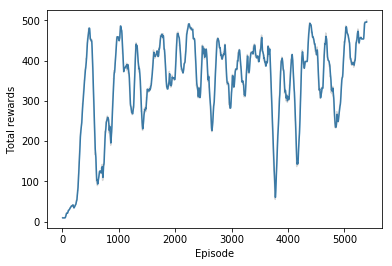

In [21]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

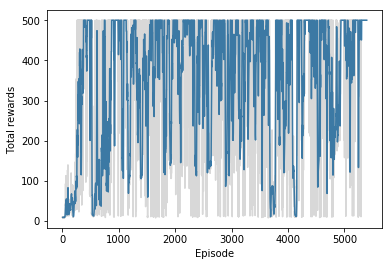

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

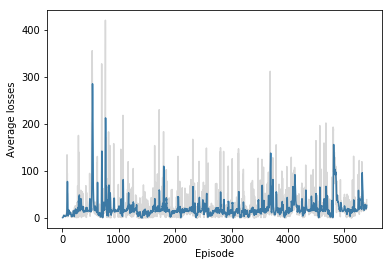

In [23]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episode/epoch
    for _ in range(10):
        total_reward = 0
        state = env.reset()
        initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
        
        # Steps/batches
        while True:
            env.render()
            action_logits, initial_state = sess.run([model.actions_logits, model.final_state],
                                                    feed_dict = {model.states: state.reshape([1, -1]), 
                                                                 model.initial_state: initial_state})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # At the end of each episode
        print('total_reward:{}'.format(total_reward))

# Close the env
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.